# Mini-FaceNet Project: MLP

In [6]:
# Import requred libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from torchvision.transforms.functional import *
import torchvision.io as io

In [7]:
# Todo 1: Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# import cv2
# import torch
# import torchvision.transforms as transforms
# import torchvision.io as io
# import time

# image_path = 'faces/pos/Aaron_Eckhart_0001.jpg'

# def func_cv(image_path):
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (96, 96))
#     image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#     return torch.from_numpy(image).unsqueeze(0)

# def func_torch(image_path):
#     transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((96, 96)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,))  # Example normalization
#     ])
#     image = io.read_image(image_path, mode=io.ImageReadMode.GRAY)
#     image = transform(image)
#     return torch.unsqueeze(image, 0)

# def test_function(function, image_path):
#     start_time = time.time()
#     function(image_path)
#     end_time = time.time()
#     print(f"Time taken by {function.__name__}: {end_time - start_time:.5f} seconds")

# # Testing the functions
# test_function(func_cv, image_path)
# test_function(func_torch, image_path)

Time taken by func_cv: 0.00064 seconds
Time taken by func_torch: 0.00062 seconds


In [4]:
# Todo 2: Define the transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomResizedCrop((96, 96), scale=(0.5, 1.0), ratio=(0.75, 1.25)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

basic_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
# Load the dataset
dataset = torchvision.datasets.ImageFolder(root='faces/', transform=transform)

In [10]:
# Todo 3: Split the dataset into train, validation and test sets

# 0.8 train, 0.2 test
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=1) 

# 0.75 x 0.8 = 0.6 train, 0.25 x 0.8 = 0.2 validation
train_dataset, valid_dataset = train_test_split(train_dataset, test_size=0.25, random_state=1)

# at the end, we have 0.6 train, 0.2 test, 0.2 validation

In [11]:
# Todo 4: Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# Todo 5: Define the model
# MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(96*96*3, 100) # 3 for RGB channels
        self.fc2 = nn.Linear(100, 10) 
        self.fc3 = nn.Linear(10, 2)  # 2 for output classes

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

model = MLP().to(device)

In [13]:
# Define losses and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Todo 6: Define the training/val loop
num_epoches = 5
train_losses = []
val_losses = []

for epoch in range(num_epoches):
    model.train()
    total_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(valid_dataset)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epoches}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Epoch [1/5], Train Loss: 0.0050, Validation Loss: 0.0038
Epoch [2/5], Train Loss: 0.0033, Validation Loss: 0.0035
Epoch [3/5], Train Loss: 0.0026, Validation Loss: 0.0033
Epoch [4/5], Train Loss: 0.0022, Validation Loss: 0.0037
Epoch [5/5], Train Loss: 0.0019, Validation Loss: 0.0034


Accuracy of the network on test images: 91 %


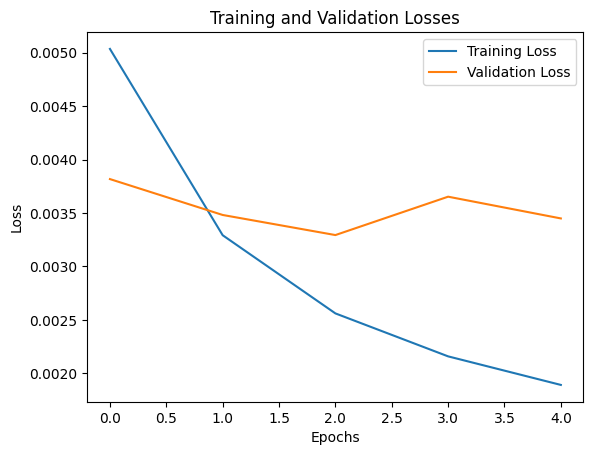

In [15]:
# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Convert to evaluation mode
model.eval()
model_scripted = torch.jit.script(model) 
model_scripted.save('minifacenet_mlp.pt') # Save

